<a href="https://colab.research.google.com/github/AlEXSH3N/713-Music-Emotion-System/blob/main/713_group_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gensim
import warnings
import string
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import Concatenate, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer

# from cuml.neighbors import KNeighborsClassifier
# from cuml.model_selection import train_test_split

In [ ]:
# !nvidia-smi
# # Colab warns and provides remediation steps if the GPUs is not compatible with RAPIDS.
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/pip-install.py

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

## Data Loading

In [2]:
# /content/drive/Shareddrives/713 Group Project/Dataset/
goemo1 = pd.read_csv(r'goemotions_1.csv')
goemo2 = pd.read_csv(r'goemotions_2.csv')
goemo3 = pd.read_csv(r'goemotions_3.csv')
geomo_all = pd.concat([goemo1, goemo2, goemo3], ignore_index=True)

print(len(goemo1), len(goemo2), len(goemo3), len(geomo_all))

70000 70000 71225 211225


## Data Exploration

In [3]:
emotion_initial_index = goemo1.columns.tolist().index('admiration')
labels = goemo1.columns.tolist()[emotion_initial_index:]
print(f"{labels} \n{len(labels)}")

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'] 
28


In [4]:
no_text_more_than_20 = 0
for text in geomo_all['text']:
    if len(text) > 50:
        no_text_more_than_20 += 1
print(f"Number of texts with more than 20 characters: {no_text_more_than_20}: {no_text_more_than_20/len(geomo_all)*100}%")

Number of texts with more than 20 characters: 136658: 64.69783406320275%


In [18]:
vec = CountVectorizer()
X = vec.fit_transform(geomo_all['text'])

words = vec.vocabulary_
sorted_words = sorted(words.items(), key=lambda x: x[1], reverse=True)
print(sorted_words)

[('ﾉωﾉ', 30698), ('카니발', 30697), ('병무청', 30696), ('개인면허', 30695), ('玛雅', 30694), ('查清', 30693), ('在中国你做什么', 30692), ('加油', 30691), ('中国人', 30690), ('ᴡᴀɪᴛ', 30689), ('ᴡᴀsᴛᴇ', 30688), ('ᴛʜɪs', 30687), ('ᴍɪɴᴜᴛᴇ', 30686), ('וליאן', 30685), ('ˈtechē', 30684), ('ˈsatʌɪə', 30683), ('ˈbɪɡət', 30682), ('ɹǝʍsuɐ', 30681), ('ɴᴏ', 30680), ('ɪs', 30679), ('ɢᴏᴏᴅ', 30678), ('òwó', 30677), ('ásáheill', 30676), ('zzzzzzz', 30675), ('zzzzzz', 30674), ('zumba', 30673), ('zullily', 30672), ('zugzwang', 30671), ('zucker', 30670), ('zucchini', 30669), ('zubac', 30668), ('zoos', 30667), ('zooming', 30666), ('zoomies', 30665), ('zoomed', 30664), ('zoom', 30663), ('zookeeper', 30662), ('zoo', 30661), ('zoning', 30660), ('zones', 30659), ('zone', 30658), ('zombies', 30657), ('zombie', 30656), ('zombey', 30655), ('zoey', 30654), ('zoetrope', 30653), ('zoe', 30652), ('zits', 30651), ('zippers', 30650), ('zipper', 30649), ('ziploc', 30648), ('zip', 30647), ('zionist', 30646), ('zionism', 30645), ('zion', 30644), ('

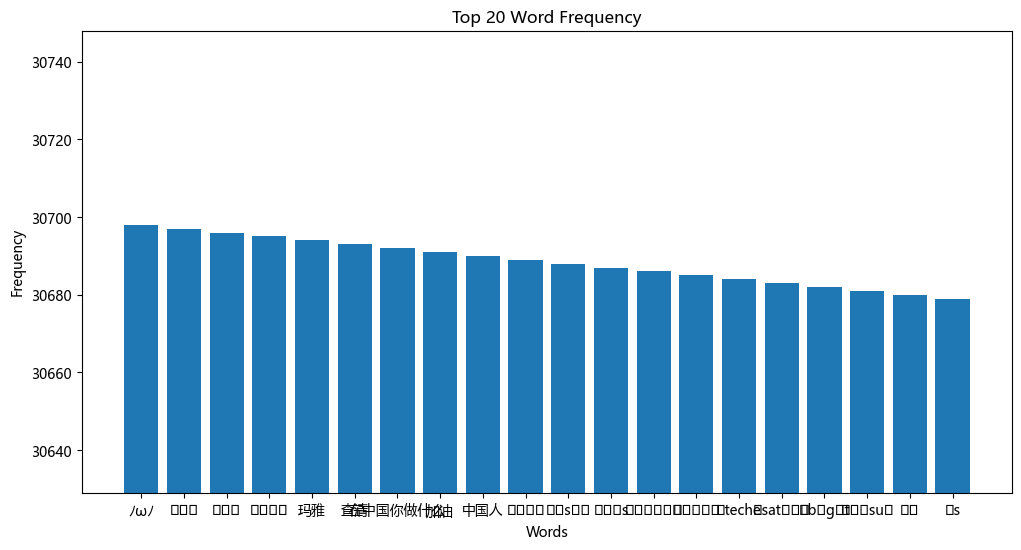

In [19]:
top_20_words = sorted_words[:20]
words, frequencies = zip(*top_20_words)

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequency')
plt.ylim(frequencies[-1] - 50, frequencies[0] + 50)
plt.show()

In [36]:
def count_punctuation(text):
    punctuations = string.punctuation
    concatenated = " ".join(text)
    punctuation_count = {}
    for char in concatenated:
        if char in punctuations:
            if char in punctuation_count:
                punctuation_count[char] += 1
            else:
                punctuation_count[char] = 1
    return punctuation_count

punctuation_count = count_punctuation(geomo_all["text"])
print(punctuation_count)


{'.': 229770, '>': 3348, '"': 12086, ',': 69932, "'": 73015, '!': 41885, '[': 37848, ']': 37831, '?': 25849, ';': 988, '/': 6151, '-': 9591, '<': 529, '$': 834, '(': 4325, ')': 5809, '#': 845, ':': 7648, '*': 9585, '_': 690, '|': 456, '%': 1022, '+': 593, '&': 403, '~': 1086, '^': 1646, '=': 461, '`': 25, '@': 138, '\\': 44, '{': 9, '}': 18}


## Data Preprocessing

In [6]:
full_train_data, test_data = train_test_split(geomo_all, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(full_train_data, test_size=0.25, random_state=42)

In [30]:
y_train = train_data[labels].values
y_val = val_data[labels].values
y_test = test_data[labels].values
y_full_train = full_train_data[labels].values

### Word Tokenizer

In [31]:
max_len = geomo_all['text'].str.len().max()

def tokenizer_and_pad_sequences(data, max_len):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data['text'])
    sequences = tokenizer.texts_to_sequences(data['text'])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    return tokenizer, padded_sequences

tokenizer, padded_sequences_train = tokenizer_and_pad_sequences(train_data, max_len)
_, padded_sequences_val = tokenizer_and_pad_sequences(val_data, max_len)
_, padded_sequences_test = tokenizer_and_pad_sequences(test_data, max_len)
_, padded_sequences_all = tokenizer_and_pad_sequences(full_train_data, max_len)

In [32]:
tokenized_texts_train = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in padded_sequences_train]
tokenized_texts_val = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in padded_sequences_val]
tokenized_texts_test = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in padded_sequences_test]
tokenized_texts_full = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in padded_sequences_all]

In [33]:
tokenized_texts = tokenized_texts_train + tokenized_texts_val + tokenized_texts_test
model = gensim.models.Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

In [34]:
def create_sentence_embeddings(tokenized_texts, model):
    sentence_embeddings = []
    for text in tokenized_texts:
        word_vectors = [model.wv[word] for word in text if word in model.wv]
        if word_vectors:
            sentence_embeddings.append(sum(word_vectors) / len(word_vectors))
        else:
            sentence_embeddings.append([0] * model.vector_size)
    return sentence_embeddings

sentence_embeddings_train = create_sentence_embeddings(tokenized_texts_train, model)
sentence_embeddings_val = create_sentence_embeddings(tokenized_texts_val, model)
sentence_embeddings_test = create_sentence_embeddings(tokenized_texts_test, model)
sentence_embeddings_full = create_sentence_embeddings(tokenized_texts_full, model)

In [35]:
X_train = np.array(sentence_embeddings_train)
X_val = np.array(sentence_embeddings_val)
X_test = np.array(sentence_embeddings_test)
X_full_train = np.array(sentence_embeddings_full)

## Models

### Traditional ML

#### KNN

In [ ]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [5, 7, 9]
}

distance_metrics = {"manhattan" : []}
# , "minkowski" : [], "euclidean" : []
warnings.filterwarnings("ignore")

## Below iteration models KNN using different combinations of hyperparameters (k value and distance metric) and assigned the accuracy score into distance_metrics dictionary
# Validation set is used to select and tune the final model
for j in range(len(distance_metrics)):
    selected_metric = list(distance_metrics.keys())[j]

    ## i value represents the k value for the KNN model
    for i in param_grid['n_neighbors']:
        knn = KNeighborsClassifier(n_neighbors = i, metric = selected_metric)
        knn.fit(X_train, y_train)
        temp_prediction = knn.predict(X_val)
        distance_metrics[selected_metric].append(round(accuracy_score(temp_prediction, y_val)*100,2))

best_metric = max(distance_metrics, key = distance_metrics.get)
best_metric_k_values = distance_metrics[best_metric]
best_k = max(distance_metrics[best_metric])
best_k_index = best_metric_k_values.index(best_k) + 1

knn_best_k = KNeighborsClassifier(n_neighbors = best_k_index, metric = best_metric)
classifier_knn = knn_best_k.fit(X_full_train, y_full_train)
prediction = knn_best_k.predict(X_test)
test_accuracy = round(accuracy_score(prediction, y_test)*100,2)

In [ ]:
print(test_accuracy)

In [ ]:
# from cuml.neighbors import KNeighborsClassifier

ModuleNotFoundError: No module named 'cuml'

### Semi transformer

In [ ]:
def build_semi_transformer(vocab_size, max_len, embedding_dim, num_heads, hidden_dim, num_emotions, dropout_rate=0.1):
    inputs = Input(shape=(max_len,), name="input_ids")

    # Embedding layer
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding")(inputs)

    # Multi-head attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)(x, x)
    attention_output = LayerNormalization()(attention_output + x)
    attention_output = Dropout(dropout_rate)(attention_output)

    # Feed-forward layer
    ff_output = Dense(units=hidden_dim, activation="relu")(attention_output)
    ff_output = Dense(units=embedding_dim, activation="linear")(ff_output)
    ff_output = LayerNormalization()(ff_output + attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    # Pooling and classification
    pooled_output = Flatten()(ff_output)
    outputs = Dense(units=num_emotions, activation="sigmoid", name="output")(pooled_output)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# embedding_dim = 128
# embedding_dim = 128
# num_heads = 8
# hidden_dim = 256
# dropout_rate = 0.2
# num_emotions = len(labels)

# model = build_semi_transformer(vocab_size=len(tokenizer.word_index) + 1,
#                                max_len=max_len,
#                                embedding_dim=embedding_dim,
#                                num_heads=num_heads,
#                                hidden_dim=hidden_dim,
#                                num_emotions=num_emotions,
#                                dropout_rate=dropout_rate)

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(padded_sequences_train, multi_labels_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
3169/3169 [==============================] - 225s 70ms/step - loss: 0.2327 - accuracy: 0.2919 - val_loss: 0.1292 - val_accuracy: 0.3787
Epoch 2/20
3169/3169 [==============================] - 220s 69ms/step - loss: 0.1206 - accuracy: 0.4091 - val_loss: 0.1279 - val_accuracy: 0.3799
Epoch 3/20
3169/3169 [==============================] - 224s 71ms/step - loss: 0.1084 - accuracy: 0.4547 - val_loss: 0.1380 - val_accuracy: 0.3635
Epoch 4/20
2050/3169 [==================>...........] - ETA: 1:11 - loss: 0.0978 - accuracy: 0.4932

KeyboardInterrupt: 